# Hand Gesture Recognition - End-to-End ML Workflow

## Project Overview

This notebook implements a production-ready hand gesture recognition system using deep learning on near-infrared images from the Leap Motion sensor.

**Dataset:** Hand gesture recognition database with 10 gestures performed by 10 subjects

**Citation:** T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, "Hand Gesture Recognition using Infrared Imagery Provided by Leap Motion Controller", Int. Conf. on Advanced Concepts for Intelligent Vision Systems, ACIVS 2016

**Gestures:**
1. Palm
2. L
3. Fist
4. Fist Moved
5. Thumb
6. Index
7. OK
8. Palm Moved
9. C
10. Down

---

## 1. Setup and Configuration

Set up reproducible environment, import dependencies, and configure paths.

In [1]:
# Standard library imports
import os
import random
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Any
import json
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
import cv2

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score
)

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Serialization
import joblib
import pickle

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


In [2]:
# Configuration class for centralized parameter management
class Config:
    """Centralized configuration for reproducibility and easy parameter tuning."""
    
    # Random seeds for reproducibility
    RANDOM_SEED = 42
    
    # Paths (environment-agnostic)
    BASE_DIR = Path.cwd()
    DATA_DIR = BASE_DIR / 'dataset'
    CHARTS_DIR = BASE_DIR / 'charts'
    OUTPUTS_DIR = BASE_DIR / 'outputs'
    ARTIFACTS_DIR = BASE_DIR / 'artifacts'
    
    # Create directories if they don't exist
    CHARTS_DIR.mkdir(exist_ok=True)
    OUTPUTS_DIR.mkdir(exist_ok=True)
    ARTIFACTS_DIR.mkdir(exist_ok=True)
    
    # Image parameters
    IMG_HEIGHT = 128
    IMG_WIDTH = 128
    IMG_CHANNELS = 1  # Grayscale for infrared
    
    # Data split ratios
    TRAIN_RATIO = 0.70
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    
    # Model parameters
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 0.001
    
    # Gesture mapping
    GESTURE_CLASSES = {
        '01_palm': 'Palm',
        '02_l': 'L',
        '03_fist': 'Fist',
        '04_fist_moved': 'Fist Moved',
        '05_thumb': 'Thumb',
        '06_index': 'Index',
        '07_ok': 'OK',
        '08_palm_moved': 'Palm Moved',
        '09_c': 'C',
        '10_down': 'Down'
    }
    
    @classmethod
    def set_seeds(cls):
        """Set all random seeds for reproducibility."""
        random.seed(cls.RANDOM_SEED)
        np.random.seed(cls.RANDOM_SEED)
        tf.random.set_seed(cls.RANDOM_SEED)
        os.environ['PYTHONHASHSEED'] = str(cls.RANDOM_SEED)
        
    @classmethod
    def save_config(cls, filepath: Path = None):
        """Save configuration to JSON file."""
        if filepath is None:
            filepath = cls.ARTIFACTS_DIR / 'config.json'
        
        config_dict = {
            'random_seed': cls.RANDOM_SEED,
            'img_height': cls.IMG_HEIGHT,
            'img_width': cls.IMG_WIDTH,
            'img_channels': cls.IMG_CHANNELS,
            'train_ratio': cls.TRAIN_RATIO,
            'val_ratio': cls.VAL_RATIO,
            'test_ratio': cls.TEST_RATIO,
            'batch_size': cls.BATCH_SIZE,
            'epochs': cls.EPOCHS,
            'learning_rate': cls.LEARNING_RATE,
            'gesture_classes': cls.GESTURE_CLASSES,
            'timestamp': datetime.now().isoformat()
        }
        
        with open(filepath, 'w') as f:
            json.dump(config_dict, f, indent=4)
        
        print(f"Configuration saved to {filepath}")

# Initialize reproducibility
Config.set_seeds()
Config.save_config()

print("Configuration initialized successfully!")
print(f"Working directory: {Config.BASE_DIR}")
print(f"Dataset directory: {Config.DATA_DIR}")

Configuration saved to /Users/ismatsamadov/hand_gesture_recognition/artifacts/config.json
Configuration initialized successfully!
Working directory: /Users/ismatsamadov/hand_gesture_recognition
Dataset directory: /Users/ismatsamadov/hand_gesture_recognition/dataset


## 2. Data Loading and Validation

Load image paths, validate dataset integrity, and create metadata dataframe.

In [3]:
def load_dataset_metadata(data_dir: Path) -> pd.DataFrame:
    """
    Load dataset and create metadata dataframe.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        DataFrame with image paths, labels, and metadata
    """
    data = []
    
    # Iterate through subject folders (00-09)
    subject_folders = sorted([f for f in data_dir.iterdir() if f.is_dir() and f.name.isdigit()])
    
    for subject_folder in subject_folders:
        subject_id = subject_folder.name
        
        # Iterate through gesture folders
        gesture_folders = sorted([f for f in subject_folder.iterdir() if f.is_dir()])
        
        for gesture_folder in gesture_folders:
            gesture_code = gesture_folder.name
            gesture_name = Config.GESTURE_CLASSES.get(gesture_code, gesture_code)
            
            # Get all images in gesture folder
            image_files = sorted(list(gesture_folder.glob('*.png')))
            
            for img_path in image_files:
                data.append({
                    'image_path': str(img_path),
                    'subject_id': subject_id,
                    'gesture_code': gesture_code,
                    'gesture_name': gesture_name,
                    'filename': img_path.name
                })
    
    df = pd.DataFrame(data)
    return df

# Load metadata
print("Loading dataset metadata...")
df_metadata = load_dataset_metadata(Config.DATA_DIR)

print(f"\nDataset loaded successfully!")
print(f"Total images: {len(df_metadata):,}")
print(f"Number of subjects: {df_metadata['subject_id'].nunique()}")
print(f"Number of gesture classes: {df_metadata['gesture_name'].nunique()}")

df_metadata.head(10)

Loading dataset metadata...

Dataset loaded successfully!
Total images: 20,000
Number of subjects: 10
Number of gesture classes: 10


,image_path,subject_id,gesture_code,gesture_name,filename
0,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0001.png
1,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0002.png
2,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0003.png
3,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0004.png
4,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0005.png
5,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0006.png
6,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0007.png
7,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0008.png
8,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0009.png
9,/Users/ismatsamadov/hand_gesture_recognition/d...,00,01_palm,Palm,frame_00_01_0010.png


In [4]:
def validate_dataset(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Perform comprehensive dataset validation.
    
    Args:
        df: Metadata dataframe
        
    Returns:
        Dictionary with validation results
    """
    validation_report = {}
    
    # Check for missing values
    missing_values = df.isnull().sum()
    validation_report['missing_values'] = missing_values.to_dict()
    
    # Check class distribution
    class_distribution = df['gesture_name'].value_counts().to_dict()
    validation_report['class_distribution'] = class_distribution
    
    # Check subject distribution
    subject_distribution = df['subject_id'].value_counts().to_dict()
    validation_report['subject_distribution'] = subject_distribution
    
    # Check if all image files exist
    missing_files = []
    for idx, row in df.iterrows():
        if not Path(row['image_path']).exists():
            missing_files.append(row['image_path'])
    
    validation_report['missing_files_count'] = len(missing_files)
    validation_report['missing_files'] = missing_files[:10]  # Store first 10
    
    # Check for duplicates
    duplicates = df.duplicated(subset=['image_path']).sum()
    validation_report['duplicate_entries'] = int(duplicates)
    
    # Dataset balance check - FIXED: Convert numpy bool to Python bool
    class_counts = df['gesture_name'].value_counts()
    validation_report['is_balanced'] = bool((class_counts.std() / class_counts.mean()) < 0.1)
    validation_report['class_imbalance_ratio'] = float(class_counts.max() / class_counts.min())
    
    return validation_report

# Validate dataset
print("Validating dataset...\n")
validation_results = validate_dataset(df_metadata)

# Display validation results
print("=" * 60)
print("DATASET VALIDATION REPORT")
print("=" * 60)

print("\n1. Missing Values:")
for col, count in validation_results['missing_values'].items():
    print(f"   - {col}: {count}")

print(f"\n2. Missing Files: {validation_results['missing_files_count']}")
print(f"\n3. Duplicate Entries: {validation_results['duplicate_entries']}")
print(f"\n4. Dataset Balanced: {validation_results['is_balanced']}")
print(f"   - Imbalance Ratio: {validation_results['class_imbalance_ratio']:.2f}")

print("\n5. Class Distribution:")
for gesture, count in sorted(validation_results['class_distribution'].items()):
    print(f"   - {gesture}: {count}")

# Save validation report
validation_path = Config.OUTPUTS_DIR / 'validation_report.json'
with open(validation_path, 'w') as f:
    json.dump(validation_results, f, indent=4)

print(f"\nValidation report saved to {validation_path}")

Validating dataset...

DATASET VALIDATION REPORT

1. Missing Values:
   - image_path: 0
   - subject_id: 0
   - gesture_code: 0
   - gesture_name: 0
   - filename: 0

2. Missing Files: 0

3. Duplicate Entries: 0

4. Dataset Balanced: True
   - Imbalance Ratio: 1.00

5. Class Distribution:
   - C: 2000
   - Down: 2000
   - Fist: 2000
   - Fist Moved: 2000
   - Index: 2000
   - L: 2000
   - OK: 2000
   - Palm: 2000
   - Palm Moved: 2000
   - Thumb: 2000

Validation report saved to /Users/ismatsamadov/hand_gesture_recognition/outputs/validation_report.json


## 3. Exploratory Data Analysis

Visualize dataset distribution and sample images.

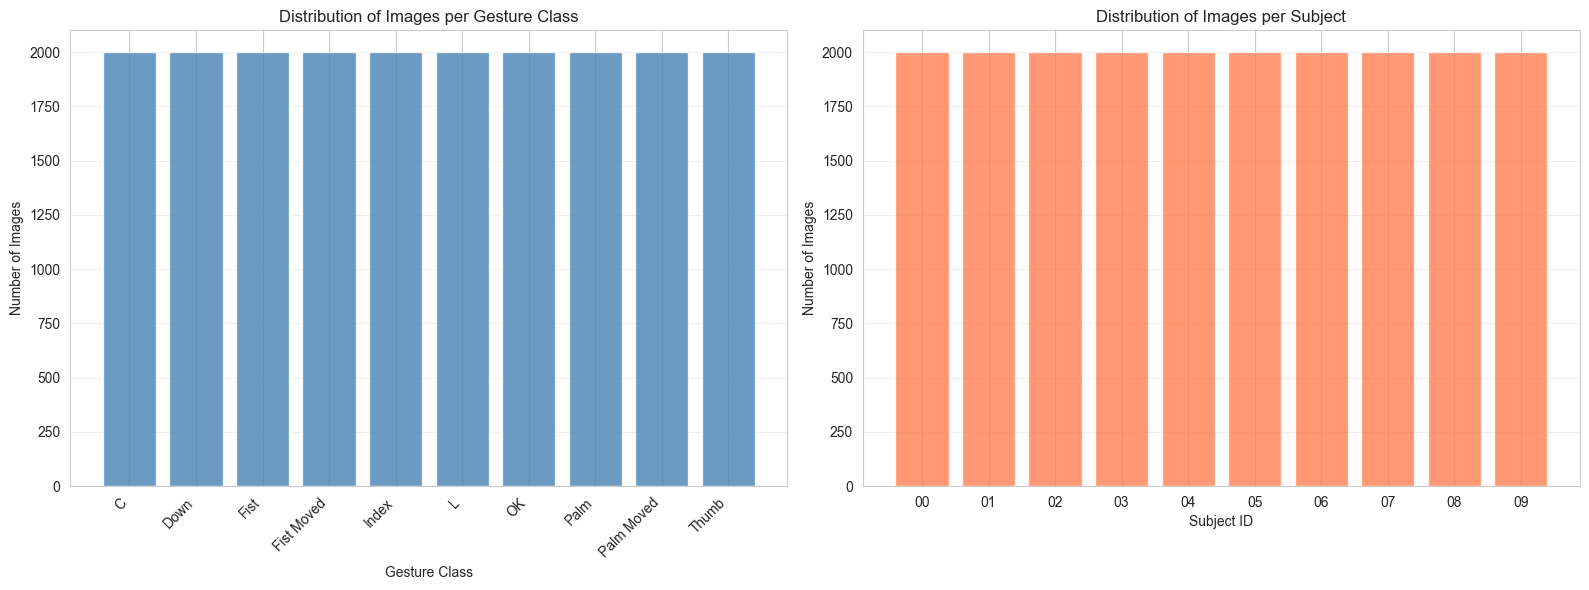

Chart saved to /Users/ismatsamadov/hand_gesture_recognition/charts/data_distribution.png


In [5]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Gesture distribution
gesture_counts = df_metadata['gesture_name'].value_counts().sort_index()
axes[0].bar(range(len(gesture_counts)), gesture_counts.values, color='steelblue', alpha=0.8)
axes[0].set_xticks(range(len(gesture_counts)))
axes[0].set_xticklabels(gesture_counts.index, rotation=45, ha='right')
axes[0].set_xlabel('Gesture Class')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Distribution of Images per Gesture Class')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Subject distribution
subject_counts = df_metadata['subject_id'].value_counts().sort_index()
axes[1].bar(range(len(subject_counts)), subject_counts.values, color='coral', alpha=0.8)
axes[1].set_xticks(range(len(subject_counts)))
axes[1].set_xticklabels(subject_counts.index)
axes[1].set_xlabel('Subject ID')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Distribution of Images per Subject')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(Config.CHARTS_DIR / 'data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Chart saved to {Config.CHARTS_DIR / 'data_distribution.png'}")

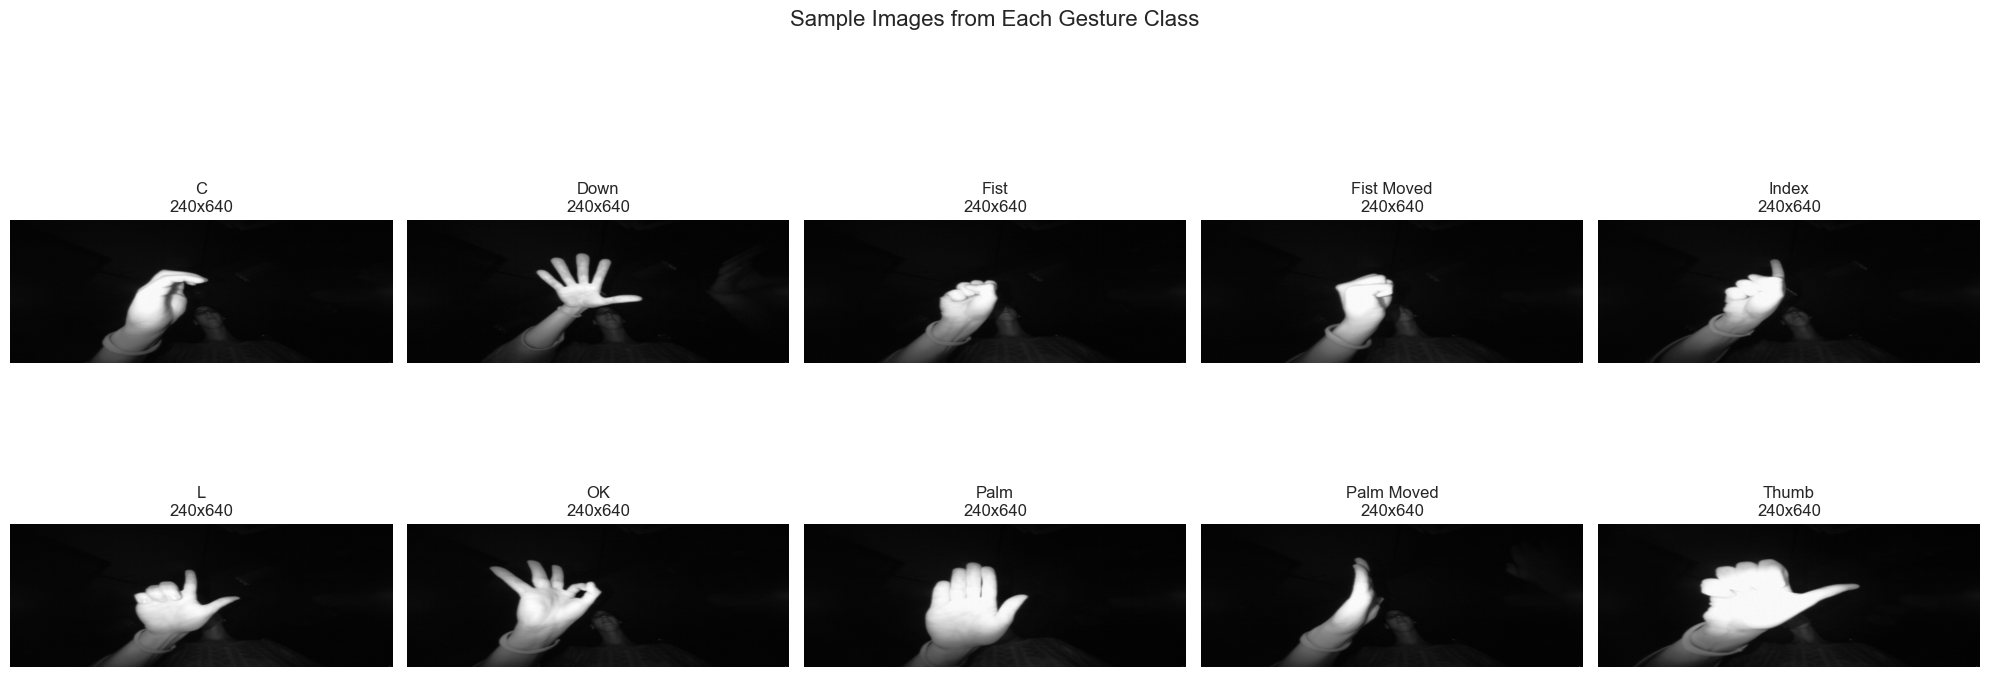

Chart saved to /Users/ismatsamadov/hand_gesture_recognition/charts/sample_gestures.png


In [6]:
# Display sample images from each gesture class
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, gesture in enumerate(sorted(df_metadata['gesture_name'].unique())):
    # Get a random sample image for this gesture
    sample = df_metadata[df_metadata['gesture_name'] == gesture].sample(1, random_state=Config.RANDOM_SEED)
    img_path = sample.iloc[0]['image_path']
    
    # Load and display image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'{gesture}\n{img.shape[0]}x{img.shape[1]}', fontsize=12)
    axes[idx].axis('off')

plt.suptitle('Sample Images from Each Gesture Class', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(Config.CHARTS_DIR / 'sample_gestures.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Chart saved to {Config.CHARTS_DIR / 'sample_gestures.png'}")

In [7]:
# Analyze image properties
print("Analyzing image properties...\n")

# Sample random images for analysis
sample_images = df_metadata.sample(100, random_state=Config.RANDOM_SEED)

image_stats = []
for _, row in sample_images.iterrows():
    img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    if img is not None:
        image_stats.append({
            'height': img.shape[0],
            'width': img.shape[1],
            'mean_intensity': img.mean(),
            'std_intensity': img.std(),
            'min_intensity': img.min(),
            'max_intensity': img.max()
        })

df_image_stats = pd.DataFrame(image_stats)

print("Image Statistics (from 100 random samples):")
print("=" * 60)
print(df_image_stats.describe())

# Save statistics
df_image_stats.describe().to_csv(Config.OUTPUTS_DIR / 'image_statistics.csv')
print(f"\nImage statistics saved to {Config.OUTPUTS_DIR / 'image_statistics.csv'}")

Analyzing image properties...

Image Statistics (from 100 random samples):
       height  width  mean_intensity  std_intensity  min_intensity  \
count   100.0  100.0      100.000000     100.000000     100.000000   
mean    240.0  640.0       23.773326      48.921568       0.410000   
std       0.0    0.0        7.887613      12.534849       0.652811   
min     240.0  640.0       12.062539      26.444620       0.000000   
25%     240.0  640.0       17.880931      40.234834       0.000000   
50%     240.0  640.0       22.367415      48.529291       0.000000   
75%     240.0  640.0       29.463595      57.637834       1.000000   
max     240.0  640.0       47.440286      79.757541       3.000000   

       max_intensity  
count     100.000000  
mean      250.680000  
std         6.928028  
min       198.000000  
25%       251.000000  
50%       252.000000  
75%       254.250000  
max       255.000000  

Image statistics saved to /Users/ismatsamadov/hand_gesture_recognition/outputs/image_s

## 4. Data Preprocessing Pipeline

Create modular preprocessing functions with no data leakage.

In [8]:
def load_and_preprocess_image(img_path: str, target_size: Tuple[int, int] = None) -> np.ndarray:
    """
    Load and preprocess a single image.
    
    Args:
        img_path: Path to image file
        target_size: Target dimensions (height, width)
        
    Returns:
        Preprocessed image array
    """
    if target_size is None:
        target_size = (Config.IMG_HEIGHT, Config.IMG_WIDTH)
    
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    
    # Resize to target dimensions
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0
    
    # Add channel dimension
    img = np.expand_dims(img, axis=-1)
    
    return img

def load_dataset_batch(df: pd.DataFrame, indices: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load a batch of images and labels.
    
    Args:
        df: Metadata dataframe
        indices: Specific indices to load (optional)
        
    Returns:
        Tuple of (images array, labels array)
    """
    if indices is not None:
        df = df.iloc[indices]
    
    images = []
    labels = []
    
    for _, row in df.iterrows():
        try:
            img = load_and_preprocess_image(row['image_path'])
            images.append(img)
            labels.append(row['gesture_name'])
        except Exception as e:
            print(f"Error loading {row['image_path']}: {e}")
            continue
    
    return np.array(images), np.array(labels)

# Test preprocessing on a single image
test_img_path = df_metadata.iloc[0]['image_path']
test_img = load_and_preprocess_image(test_img_path)

print("Preprocessing test:")
print(f"Original image path: {test_img_path}")
print(f"Preprocessed shape: {test_img.shape}")
print(f"Data type: {test_img.dtype}")
print(f"Value range: [{test_img.min():.3f}, {test_img.max():.3f}]")

Preprocessing test:
Original image path: /Users/ismatsamadov/hand_gesture_recognition/dataset/00/01_palm/frame_00_01_0001.png
Preprocessed shape: (128, 128, 1)
Data type: float32
Value range: [0.012, 0.890]


## 5. Train/Validation/Test Split

Split data with stratification to maintain class balance.

In [9]:
def create_stratified_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Create stratified train/val/test split.
    
    Args:
        df: Metadata dataframe
        
    Returns:
        Tuple of (train_df, val_df, test_df)
    """
    # First split: separate test set
    train_val_df, test_df = train_test_split(
        df,
        test_size=Config.TEST_RATIO,
        stratify=df['gesture_name'],
        random_state=Config.RANDOM_SEED
    )
    
    # Second split: separate validation from training
    val_ratio_adjusted = Config.VAL_RATIO / (Config.TRAIN_RATIO + Config.VAL_RATIO)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_ratio_adjusted,
        stratify=train_val_df['gesture_name'],
        random_state=Config.RANDOM_SEED
    )
    
    return train_df, val_df, test_df

# Create splits
print("Creating stratified data splits...\n")
train_df, val_df, test_df = create_stratified_split(df_metadata)

print("Split Summary:")
print("=" * 60)
print(f"Training set:   {len(train_df):6,} images ({len(train_df)/len(df_metadata)*100:.1f}%)")
print(f"Validation set: {len(val_df):6,} images ({len(val_df)/len(df_metadata)*100:.1f}%)")
print(f"Test set:       {len(test_df):6,} images ({len(test_df)/len(df_metadata)*100:.1f}%)")
print(f"Total:          {len(df_metadata):6,} images")

# Verify stratification
print("\nClass distribution verification:")
print("=" * 60)

split_distribution = pd.DataFrame({
    'Train': train_df['gesture_name'].value_counts().sort_index(),
    'Val': val_df['gesture_name'].value_counts().sort_index(),
    'Test': test_df['gesture_name'].value_counts().sort_index()
})

print(split_distribution)

# Save split information
split_distribution.to_csv(Config.OUTPUTS_DIR / 'split_distribution.csv')
print(f"\nSplit distribution saved to {Config.OUTPUTS_DIR / 'split_distribution.csv'}")

Creating stratified data splits...

Split Summary:
Training set:   14,000 images (70.0%)
Validation set:  3,000 images (15.0%)
Test set:        3,000 images (15.0%)
Total:          20,000 images

Class distribution verification:
              Train  Val  Test
gesture_name                  
C              1400  300   300
Down           1400  300   300
Fist           1400  300   300
Fist Moved     1400  300   300
Index          1400  300   300
L              1400  300   300
OK             1400  300   300
Palm           1400  300   300
Palm Moved     1400  300   300
Thumb          1400  300   300

Split distribution saved to /Users/ismatsamadov/hand_gesture_recognition/outputs/split_distribution.csv


In [10]:
# Prepare label encoding
label_encoder = LabelEncoder()
label_encoder.fit(df_metadata['gesture_name'])

# Save label encoder
joblib.dump(label_encoder, Config.ARTIFACTS_DIR / 'label_encoder.pkl')

print("Label Encoder:")
print("=" * 60)
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{idx}: {class_name}")

print(f"\nLabel encoder saved to {Config.ARTIFACTS_DIR / 'label_encoder.pkl'}")

Label Encoder:
0: C
1: Down
2: Fist
3: Fist Moved
4: Index
5: L
6: OK
7: Palm
8: Palm Moved
9: Thumb

Label encoder saved to /Users/ismatsamadov/hand_gesture_recognition/artifacts/label_encoder.pkl


## 6. Data Loading and Augmentation

Load images into memory and prepare data generators with augmentation.

In [11]:
# Load training data
print("Loading training data...")
X_train, y_train_labels = load_dataset_batch(train_df)
y_train = label_encoder.transform(y_train_labels)
y_train_cat = to_categorical(y_train, num_classes=len(label_encoder.classes_))

print(f"Training data loaded: {X_train.shape}")
print(f"Training labels shape: {y_train_cat.shape}")

# Load validation data
print("\nLoading validation data...")
X_val, y_val_labels = load_dataset_batch(val_df)
y_val = label_encoder.transform(y_val_labels)
y_val_cat = to_categorical(y_val, num_classes=len(label_encoder.classes_))

print(f"Validation data loaded: {X_val.shape}")
print(f"Validation labels shape: {y_val_cat.shape}")

# Load test data
print("\nLoading test data...")
X_test, y_test_labels = load_dataset_batch(test_df)
y_test = label_encoder.transform(y_test_labels)
y_test_cat = to_categorical(y_test, num_classes=len(label_encoder.classes_))

print(f"Test data loaded: {X_test.shape}")
print(f"Test labels shape: {y_test_cat.shape}")

Loading training data...
Training data loaded: (14000, 128, 128, 1)
Training labels shape: (14000, 10)

Loading validation data...
Validation data loaded: (3000, 128, 128, 1)
Validation labels shape: (3000, 10)

Loading test data...
Test data loaded: (3000, 128, 128, 1)
Test labels shape: (3000, 10)


In [12]:
# Data augmentation (applied only to training data)
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator()

print("Data augmentation configured for training set.")
print("No augmentation applied to validation and test sets.")

Data augmentation configured for training set.
No augmentation applied to validation and test sets.


## 7. Model Architecture

Build a Convolutional Neural Network for gesture recognition.

In [13]:
def build_cnn_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    """
    Build CNN model architecture for hand gesture recognition.
    
    Args:
        input_shape: Input image shape (height, width, channels)
        num_classes: Number of output classes
        
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build model
input_shape = (Config.IMG_HEIGHT, Config.IMG_WIDTH, Config.IMG_CHANNELS)
num_classes = len(label_encoder.classes_)

model = build_cnn_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("Model Architecture:")
print("=" * 60)
model.summary()

# Save model architecture
with open(Config.OUTPUTS_DIR / 'model_architecture.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

print(f"\nModel architecture saved to {Config.OUTPUTS_DIR / 'model_architecture.txt'}")

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,712,810 (33.24 MB)

 Trainable params: 8,711,146 (33.23 MB)

 Non-trainable params: 1,664 (6.50 KB)


Model architecture saved to /Users/ismatsamadov/hand_gesture_recognition/outputs/model_architecture.txt


## 8. Model Training

Train model with callbacks for monitoring and early stopping.

In [14]:
# Define callbacks
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=str(Config.ARTIFACTS_DIR / 'best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

csv_logger = callbacks.CSVLogger(
    str(Config.OUTPUTS_DIR / 'training_log.csv'),
    append=False
)

print("Callbacks configured:")
print("  - ModelCheckpoint: Save best model based on val_accuracy")
print("  - EarlyStopping: Stop if val_loss doesn't improve for 10 epochs")
print("  - ReduceLROnPlateau: Reduce learning rate if val_loss plateaus")
print("  - CSVLogger: Log training metrics to CSV")

Callbacks configured:
  - ModelCheckpoint: Save best model based on val_accuracy
  - EarlyStopping: Stop if val_loss doesn't improve for 10 epochs
  - ReduceLROnPlateau: Reduce learning rate if val_loss plateaus
  - CSVLogger: Log training metrics to CSV


In [ ]:
# Train model
print("\nStarting model training...")
print("=" * 60)

history = model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=Config.BATCH_SIZE),
    epochs=Config.EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=[checkpoint_callback, early_stopping, reduce_lr, csv_logger],
    verbose=1
)

print("\nTraining completed!")


Starting model training...
Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.3813 - loss: 2.0548 - precision: 0.4823 - recall: 0.2708
Epoch 1: val_accuracy improved from None to 0.11333, saving model to /Users/ismatsamadov/hand_gesture_recognition/artifacts/best_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 211s 474ms/step - accuracy: 0.5520 - loss: 1.3839 - precision: 0.6806 - recall: 0.4487 - val_accuracy: 0.1133 - val_loss: 5.5907 - val_precision: 0.1240 - val_recall: 0.1093 - learning_rate: 0.0010
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8454 - loss: 0.4401 - precision: 0.8805 - recall: 0.8081

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Over Epochs')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Model Loss Over Epochs')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Model Precision Over Epochs')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Model Recall Over Epochs')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(Config.CHARTS_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history chart saved to {Config.CHARTS_DIR / 'training_history.png'}")

## 9. Model Evaluation

Comprehensive evaluation on test set with multiple metrics.

In [ ]:
# Load best model
best_model = keras.models.load_model(Config.ARTIFACTS_DIR / 'best_model.keras')

# Evaluate on test set
print("Evaluating model on test set...")
print("=" * 60)

test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(X_test, y_test_cat, verbose=0)

print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")

# Get predictions
y_pred_probs = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate additional metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"\nWeighted Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

In [ ]:
# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 60)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=4)
print(report)

# Save classification report
with open(Config.OUTPUTS_DIR / 'classification_report.txt', 'w') as f:
    f.write("Classification Report - Test Set\n")
    f.write("=" * 60 + "\n")
    f.write(report)

# Save as structured data
report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(Config.OUTPUTS_DIR / 'classification_report.csv')

print(f"\nClassification report saved to {Config.OUTPUTS_DIR / 'classification_report.txt'}")
print(f"Classification report (CSV) saved to {Config.OUTPUTS_DIR / 'classification_report.csv'}")

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig(Config.CHARTS_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save confusion matrix data
pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_).to_csv(
    Config.OUTPUTS_DIR / 'confusion_matrix.csv'
)

print(f"Confusion matrix chart saved to {Config.CHARTS_DIR / 'confusion_matrix.png'}")
print(f"Confusion matrix data saved to {Config.OUTPUTS_DIR / 'confusion_matrix.csv'}")

In [ ]:
# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Proportion'}
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig(Config.CHARTS_DIR / 'confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Normalized confusion matrix saved to {Config.CHARTS_DIR / 'confusion_matrix_normalized.png'}")

In [ ]:
# Per-class performance visualization
class_metrics = []
for i, class_name in enumerate(label_encoder.classes_):
    class_indices = np.where(y_test == i)[0]
    class_pred = y_pred[class_indices]
    class_accuracy = (class_pred == i).sum() / len(class_pred)
    
    class_metrics.append({
        'Gesture': class_name,
        'Accuracy': class_accuracy,
        'Support': len(class_indices)
    })

df_class_metrics = pd.DataFrame(class_metrics)

# Plot per-class accuracy
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(df_class_metrics['Gesture'], df_class_metrics['Accuracy'], color='steelblue', alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Gesture Class')
ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy on Test Set')
ax.set_ylim([0, 1.1])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(Config.CHARTS_DIR / 'per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Save per-class metrics
df_class_metrics.to_csv(Config.OUTPUTS_DIR / 'per_class_metrics.csv', index=False)

print(f"Per-class accuracy chart saved to {Config.CHARTS_DIR / 'per_class_accuracy.png'}")
print(f"Per-class metrics saved to {Config.OUTPUTS_DIR / 'per_class_metrics.csv'}")

In [ ]:
# Sample predictions visualization
num_samples = 20
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    img = X_test[sample_idx]
    true_label = label_encoder.classes_[y_test[sample_idx]]
    pred_label = label_encoder.classes_[y_pred[sample_idx]]
    confidence = y_pred_probs[sample_idx][y_pred[sample_idx]]
    
    # Display image
    axes[idx].imshow(img.squeeze(), cmap='gray')
    
    # Set title color based on correctness
    color = 'green' if true_label == pred_label else 'red'
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}',
                       color=color, fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Predictions on Test Set (Green=Correct, Red=Incorrect)', fontsize=14, y=1.00)
plt.tight_layout()
plt.savefig(Config.CHARTS_DIR / 'sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Sample predictions chart saved to {Config.CHARTS_DIR / 'sample_predictions.png'}")

In [ ]:
# Save comprehensive evaluation summary
evaluation_summary = {
    'model_info': {
        'architecture': 'Custom CNN',
        'total_parameters': int(best_model.count_params()),
        'input_shape': list(input_shape),
        'num_classes': int(num_classes)
    },
    'dataset_info': {
        'total_images': int(len(df_metadata)),
        'train_images': int(len(train_df)),
        'val_images': int(len(val_df)),
        'test_images': int(len(test_df))
    },
    'test_metrics': {
        'accuracy': float(test_accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'loss': float(test_loss)
    },
    'training_info': {
        'epochs_trained': len(history.history['loss']),
        'batch_size': Config.BATCH_SIZE,
        'learning_rate': Config.LEARNING_RATE,
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'best_val_accuracy': float(max(history.history['val_accuracy']))
    },
    'timestamp': datetime.now().isoformat()
}

# Save evaluation summary
with open(Config.OUTPUTS_DIR / 'evaluation_summary.json', 'w') as f:
    json.dump(evaluation_summary, f, indent=4)

print("\nEvaluation Summary:")
print("=" * 60)
print(json.dumps(evaluation_summary, indent=2))
print(f"\nEvaluation summary saved to {Config.OUTPUTS_DIR / 'evaluation_summary.json'}")

## 10. Model Persistence and Artifacts

Save all model artifacts for production deployment.

In [ ]:
# Save final model in multiple formats
print("Saving model artifacts...")
print("=" * 60)

# 1. Keras format (recommended)
best_model.save(Config.ARTIFACTS_DIR / 'final_model.keras')
print(f"✓ Model saved in Keras format: {Config.ARTIFACTS_DIR / 'final_model.keras'}")

# 2. SavedModel format (for TensorFlow Serving)
best_model.save(Config.ARTIFACTS_DIR / 'saved_model', save_format='tf')
print(f"✓ Model saved in SavedModel format: {Config.ARTIFACTS_DIR / 'saved_model'}")

# 3. Save model weights only
best_model.save_weights(Config.ARTIFACTS_DIR / 'model_weights.h5')
print(f"✓ Model weights saved: {Config.ARTIFACTS_DIR / 'model_weights.h5'}")

# 4. Save label encoder (already saved earlier)
print(f"✓ Label encoder saved: {Config.ARTIFACTS_DIR / 'label_encoder.pkl'}")

# 5. Save training history
history_dict = {
    'history': {key: [float(val) for val in values] for key, values in history.history.items()}
}
with open(Config.ARTIFACTS_DIR / 'training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=4)
print(f"✓ Training history saved: {Config.ARTIFACTS_DIR / 'training_history.json'}")

# 6. Save preprocessing parameters
preprocessing_params = {
    'target_size': (Config.IMG_HEIGHT, Config.IMG_WIDTH),
    'normalization': 'divide_by_255',
    'color_mode': 'grayscale',
    'interpolation': 'area'
}
with open(Config.ARTIFACTS_DIR / 'preprocessing_params.json', 'w') as f:
    json.dump(preprocessing_params, f, indent=4)
print(f"✓ Preprocessing parameters saved: {Config.ARTIFACTS_DIR / 'preprocessing_params.json'}")

print("\n" + "=" * 60)
print("All artifacts saved successfully!")
print("=" * 60)

## 11. Inference Pipeline

Demonstrate how to use the saved model for predictions.

In [ ]:
def predict_gesture(image_path: str, model_path: str = None, 
                    label_encoder_path: str = None) -> Dict[str, Any]:
    """
    Production-ready inference function.
    
    Args:
        image_path: Path to input image
        model_path: Path to saved model (optional)
        label_encoder_path: Path to label encoder (optional)
        
    Returns:
        Dictionary with prediction results
    """
    # Load model and encoder if not provided
    if model_path is None:
        model_path = Config.ARTIFACTS_DIR / 'final_model.keras'
    if label_encoder_path is None:
        label_encoder_path = Config.ARTIFACTS_DIR / 'label_encoder.pkl'
    
    model = keras.models.load_model(model_path)
    encoder = joblib.load(label_encoder_path)
    
    # Preprocess image
    img = load_and_preprocess_image(image_path)
    img_batch = np.expand_dims(img, axis=0)
    
    # Predict
    predictions = model.predict(img_batch, verbose=0)[0]
    
    # Get top prediction
    predicted_class_idx = np.argmax(predictions)
    predicted_class = encoder.classes_[predicted_class_idx]
    confidence = predictions[predicted_class_idx]
    
    # Get top 3 predictions
    top3_indices = np.argsort(predictions)[::-1][:3]
    top3_predictions = [
        {
            'class': encoder.classes_[idx],
            'confidence': float(predictions[idx])
        }
        for idx in top3_indices
    ]
    
    return {
        'predicted_gesture': predicted_class,
        'confidence': float(confidence),
        'top_3_predictions': top3_predictions,
        'all_probabilities': {encoder.classes_[i]: float(predictions[i]) 
                             for i in range(len(predictions))}
    }

# Test inference on a random test image
test_image_path = df_metadata.sample(1, random_state=42).iloc[0]['image_path']
result = predict_gesture(test_image_path)

print("Inference Test:")
print("=" * 60)
print(f"Image: {test_image_path}")
print(f"\nPredicted Gesture: {result['predicted_gesture']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"\nTop 3 Predictions:")
for i, pred in enumerate(result['top_3_predictions'], 1):
    print(f"  {i}. {pred['class']}: {pred['confidence']:.2%}")

## 12. Final Summary and Next Steps

Project summary and recommendations for deployment.

In [ ]:
print("="*70)
print(" " * 15 + "PROJECT COMPLETION SUMMARY")
print("="*70)

print("\n📁 Directory Structure:")
print(f"   └── {Config.CHARTS_DIR.name}/     : {len(list(Config.CHARTS_DIR.glob('*')))} visualization files")
print(f"   └── {Config.OUTPUTS_DIR.name}/    : {len(list(Config.OUTPUTS_DIR.glob('*')))} output files")
print(f"   └── {Config.ARTIFACTS_DIR.name}/  : {len(list(Config.ARTIFACTS_DIR.glob('*')))} model artifacts")

print("\n📊 Model Performance:")
print(f"   • Test Accuracy:  {test_accuracy:.2%}")
print(f"   • Test Precision: {precision:.2%}")
print(f"   • Test Recall:    {recall:.2%}")
print(f"   • Test F1-Score:  {f1:.2%}")

print("\n🔧 Saved Artifacts:")
artifacts = list(Config.ARTIFACTS_DIR.glob('*'))
for artifact in sorted(artifacts):
    if artifact.is_file():
        size_mb = artifact.stat().st_size / (1024 * 1024)
        print(f"   • {artifact.name:40s} ({size_mb:.2f} MB)")
    elif artifact.is_dir():
        print(f"   • {artifact.name:40s} (directory)")

print("\n📈 Generated Visualizations:")
charts = list(Config.CHARTS_DIR.glob('*.png'))
for chart in sorted(charts):
    print(f"   • {chart.name}")

print("\n📄 Generated Outputs:")
outputs = list(Config.OUTPUTS_DIR.glob('*'))
for output in sorted(outputs):
    print(f"   • {output.name}")

print("\n🎯 Next Steps:")
print("   1. Deploy model using TensorFlow Serving or Flask API")
print("   2. Implement model monitoring and retraining pipeline")
print("   3. Test on real-world data from Leap Motion sensor")
print("   4. Consider ensemble methods or transfer learning for improvement")
print("   5. Optimize model for edge deployment if needed (quantization, pruning)")

print("\n" + "="*70)
print(" " * 20 + "🎉 PROJECT COMPLETE! 🎉")
print("="*70)